In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error

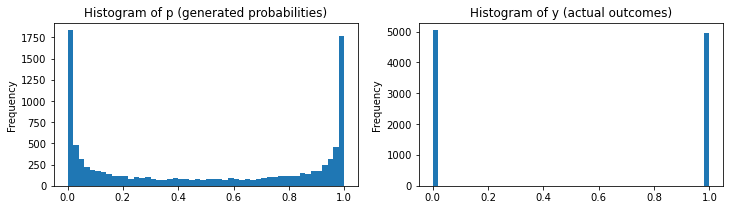

In [2]:
def logit(p):
    return np.log(p/(1-p))

def original_brier_score(forecast, actual_outcome, category_size=0.005):
    bins = np.arange(0, 1+category_size, category_size)
    assigned_bins = np.digitize(forecast, bins)
    aux = pd.DataFrame({'forecast':forecast, 'actual_outcome':actual_outcome, 'assigned_bins':assigned_bins})
    result = pd.DataFrame({
        'square_error':aux.groupby('assigned_bins').apply(lambda x: sum((x['forecast']-x['actual_outcome'])**2)),
        'actual_frequencies':aux.groupby('assigned_bins')['actual_outcome'].mean(),
        'mean_forecast':aux.groupby('assigned_bins')['forecast'].mean()}).sort_index()
    return result, bins

def generate_logit_samples(μ, cov, β0, β, N=100_000):
    # Simulation
    X = np.random.multivariate_normal(μ, cov, size=N)
    log_ps = β0 + X @ β
    ps = np.exp(log_ps)/(1+np.exp(log_ps))
    y = (np.random.uniform(size=N) <= ps).astype(int) # -> if p = 0.8, the uniform sample has 80% prob of being 1
    
    # Putting the results into a dataframe for convenience
    samples = pd.DataFrame(X)
    samples.columns = [f'x_{i}' for i in range(1, len(μ)+ 1)]
    samples['p'] = ps
    samples['y'] = y
    return samples


ρ12 = 0.5
ρ13 = 0.4
ρ23 = 0.3
cov = [[1, ρ12, ρ13], # Note that I can get away with using correlations as covariances only because *all* standard devs are 1
       [ρ12, 1, ρ23],
       [ρ13, ρ23, 1]]
μ = np.zeros(3)

β = np.array([0.3, 0.4, 4])

samples = generate_logit_samples(μ, cov, 0, β, N=10_000)

fig, axarray = plt.subplots(1, 2, figsize=(6*2, 3))
pd.Series(samples['p']).plot.hist(bins=50, ax=axarray[0], title='Histogram of p (generated probabilities)');
pd.Series(samples['y']).plot.hist(bins=50, ax=axarray[1], title='Histogram of y (actual outcomes)');

In [3]:
samples = sm.add_constant(samples)

info_known_to_forecaster1 = samples[['const', 'x_1']] # They obviously know the outcomes as well
info_known_to_forecaster2 = samples[['const', 'x_2']]
info_known_to_forecaster3 = samples[['const', 'x_3']]

model_forecaster1 = sm.Logit(samples['y'], info_known_to_forecaster1)
model_forecaster2 = sm.Logit(samples['y'], info_known_to_forecaster2)
model_forecaster3 = sm.Logit(samples['y'], info_known_to_forecaster3)

results_forecaster1 = model_forecaster1.fit()
results_forecaster2 = model_forecaster2.fit()
results_forecaster3 = model_forecaster3.fit()

Optimization terminated successfully.
         Current function value: 0.625780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.284964
         Iterations 8


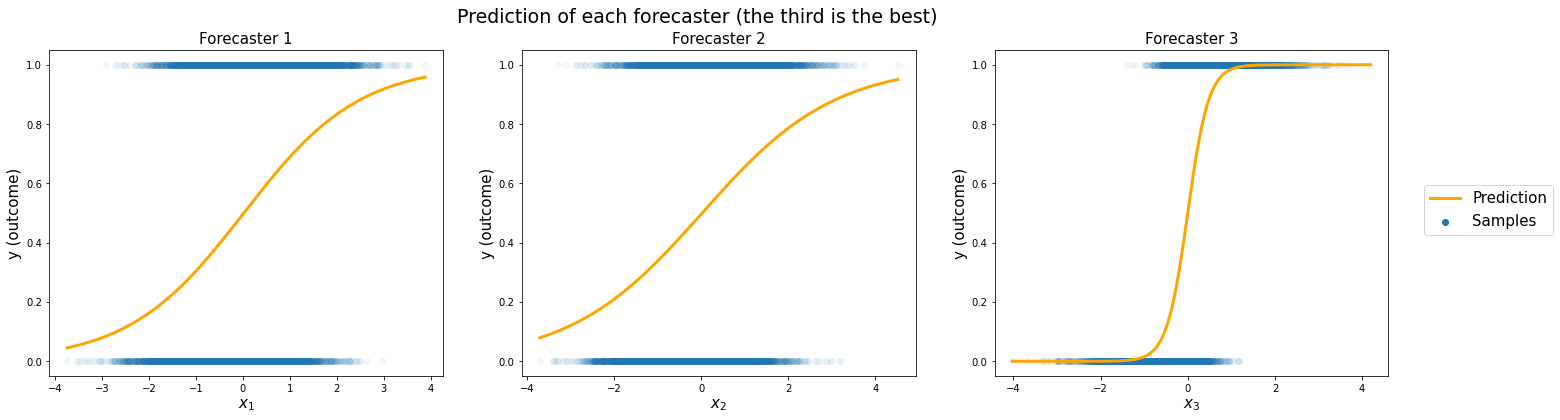

In [4]:
fig, axarray = plt.subplots(1, 3, figsize=(8*3,6))

x1 = sm.add_constant(np.linspace(samples['x_1'].min(), samples['x_1'].max(), 1000).reshape(-1, 1))
x2 = sm.add_constant(np.linspace(samples['x_2'].min(), samples['x_2'].max(), 1000).reshape(-1, 1))
x3 = sm.add_constant(np.linspace(samples['x_3'].min(), samples['x_3'].max(), 1000).reshape(-1, 1))

axarray[0].plot(x1[:, 1], results_forecaster1.predict(x1), color='orange', lw=3, label='Prediction')
axarray[1].plot(x2[:, 1], results_forecaster2.predict(x2), color='orange', lw=3)
axarray[2].plot(x3[:, 1], results_forecaster3.predict(x3), color='orange', lw=3)

for i, ax in enumerate(axarray):
    ax.scatter(samples[f'x_{i+1}'], samples['y'], alpha=0.05, label='Samples' if i == 0 else None)
    ax.set_xlabel(f'$x_{i+1}$', fontsize=15)
    ax.set_ylabel('y (outcome)', fontsize=15)
    ax.set_title(f'Forecaster {i+1}', fontsize=15)

legend = fig.legend(fontsize=15, loc='center right')
for lh in legend.legendHandles: 
    lh.set_alpha(1)
fig.suptitle("Prediction of each forecaster (the third is the best)", fontsize=19);

In [5]:
p1 = results_forecaster1.predict(samples[['const', 'x_1']])
p2 = results_forecaster2.predict(samples[['const', 'x_2']])
p3 = results_forecaster3.predict(samples[['const', 'x_3']])

p = p1*p2*p3/(p1*p2*p3+(1-p1)*(1-p2)*(1-p3))

<AxesSubplot:xlabel='assigned_bins'>

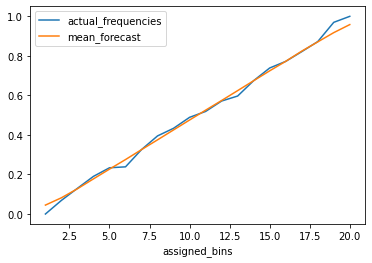

In [6]:
result, bins = original_brier_score(p1, samples['y'], 0.05)
result.iloc[:, [-2, -1]].plot()

In [7]:
pd.Series(bins).head(10)

0    0.00
1    0.05
2    0.10
3    0.15
4    0.20
5    0.25
6    0.30
7    0.35
8    0.40
9    0.45
dtype: float64

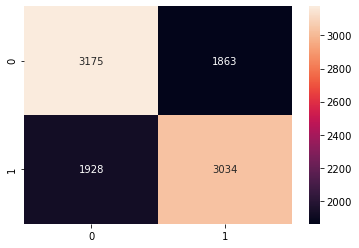

In [8]:
sns.heatmap(confusion_matrix(samples['y'], np.round(p2)), annot=True, fmt='g');

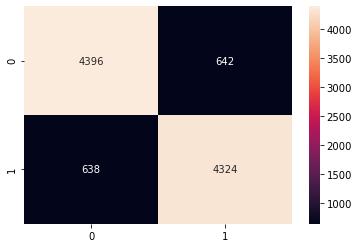

In [9]:
sns.heatmap(confusion_matrix(samples['y'], np.round(p3)), annot=True, fmt='g');

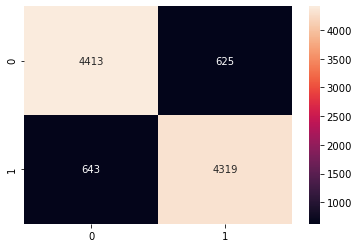

In [10]:
sns.heatmap(confusion_matrix(samples['y'], np.round(p)), annot=True, fmt='g');